In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu102
0.10.0+cu102


In [ ]:
torch.manual_seed(111)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


The function has two parts:
  1.   transforms.ToTensor() converts the data to a PyTorch tensor.
  2.   transforms.Normalize() converts the range of the tensor coefficients.<br>
  
The original coefficients given by transforms.ToTensor() range from 0 to 1, and since the image backgrounds are black, most of the coefficients are equal to 0 when they’re represented using this range.<br>

The transforms.Normalize() changes the range of the coefficients to -1 to 1 by subtracting 0.5 from the original coefficients and dividing the result by 0.5. With this transformation, the number of elements equal to 0 in the input samples is dramatically reduced, which helps in training the models.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

The arguments of *transforms.Normalize()* are two tuples, (M₁, ..., Mₙ) and (S₁, ..., Sₙ), with n representing the number of channels of the images. Grayscale images such as those in MNIST dataset have only one channel, so the tuples have only one value. Then, for each channel i of the image, transforms.Normalize() subtracts Mᵢ from the coefficients and divides the result by Sᵢ.<br>
The argument ***download=True*** ensures that the first time you run the above code, the MNIST dataset will be downloaded and stored in the current directory, as indicated by the argument root.

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

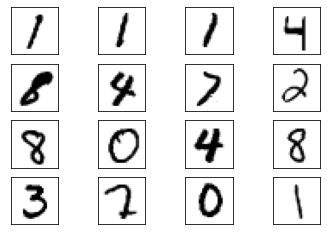

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

To input the image coefficients into the MLP neural network, you vectorize them so that the neural network receives vectors with 784 coefficients.

The vectorization occurs in the first line of .forward(), as the call to x.view() converts the shape of the input tensor. In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up. After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [ ]:
discriminator = Discriminator().to(device=device)

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

 hyperbolic tangent function Tanh() as the activation of the output layer since the output coefficients should be in the interval from -1 to 1.

###Training the Models

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):

        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        
        all_samples = torch.cat((real_samples, generated_samples))

        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function( output_discriminator, all_samples_labels )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function( output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5754522681236267
Epoch: 0 Loss G.: 0.49072185158729553
Epoch: 1 Loss D.: 0.1572021096944809
Epoch: 1 Loss G.: 6.16936731338501
Epoch: 2 Loss D.: 0.06825379282236099
Epoch: 2 Loss G.: 5.0977888107299805
Epoch: 3 Loss D.: 0.2771102786064148
Epoch: 3 Loss G.: 6.635896682739258
Epoch: 4 Loss D.: 0.04513409733772278
Epoch: 4 Loss G.: 6.9157490730285645
Epoch: 5 Loss D.: 0.0749567300081253
Epoch: 5 Loss G.: 5.378217697143555
Epoch: 6 Loss D.: 0.06429428607225418
Epoch: 6 Loss G.: 2.8610262870788574
Epoch: 7 Loss D.: 0.1691613495349884
Epoch: 7 Loss G.: 4.562799453735352
Epoch: 8 Loss D.: 0.2873043417930603
Epoch: 8 Loss G.: 2.457916021347046
Epoch: 9 Loss D.: 0.3149438798427582
Epoch: 9 Loss G.: 2.113518714904785
Epoch: 10 Loss D.: 0.23161186277866364
Epoch: 10 Loss G.: 2.2165541648864746
Epoch: 11 Loss D.: 0.34673571586608887
Epoch: 11 Loss G.: 1.5526602268218994
Epoch: 12 Loss D.: 0.370083749294281
Epoch: 12 Loss G.: 1.8110110759735107
Epoch: 13 Loss D.: 0.4178011417388

### Checking the Samples Generated by the GAN

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

To plot generated_samples, you need to move the data back to the CPU in case it’s running on the GPU. For that, you can simply call .cpu(). As you did previously, you also need to call .detach() before using Matplotlib to plot the data:

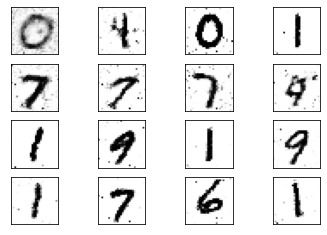

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])